# Sample captions & visualize attention

In [1]:
import sys; sys.argv=['']; del sys
import numpy as np
import os
from args import get_parser
from utils.dataloader import DataLoader
from utils.config import get_opt
from utils.lang_proc import idx2word, sample
from model import get_model, language_model,image_model
from keras import backend as K
import pickle

Using TensorFlow backend.


In [2]:
parser = get_parser()
args_dict = parser.parse_args()
args_dict.mode = 'test'
args_dict.bs = 1
args_dict.cnn_train = False
args_dict.dr = True
args_dict.bn = True
args_dict.sgate = True
args_dict.temperature = -1

Choose model weights to load:

In [3]:
args_dict.model_file = '/work/asalvador/sat_keras/models/s.dr.bn_weights_e2_CIDEr0.58.h5'

Initialize model and load weights:

In [4]:
model = get_model(args_dict)
weights = args_dict.model_file
model.load_weights(weights)
print model.summary()
model.compile(optimizer=None,loss='categorical_crossentropy',sample_weight_mode="temporal")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image (InputLayer)               (1, 224, 224, 3)      0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (1, 7, 7, 2048)       23587712    image[0][0]                      
____________________________________________________________________________________________________
prev_words (InputLayer)          (1, 1)                0                                            
____________________________________________________________________________________________________
model_2 (Model)                  (1, 1, 8855)          15908504    model_1[1][0]                    
                                                                   prev_words[0][0]        

Initialize the generator to yield samples:

In [5]:
dataloader = DataLoader(args_dict)
N = args_dict.bs
val_gen = dataloader.generator('test',batch_size=args_dict.bs,train_flag=False) # N samples

Create the extractor that outputs attention weights and class probabilities. To do this, we separately save to disk the weights of the two model parts, and load them.

In [6]:
from keras.models import load_model
from keras.layers import Input
tmp_dir = os.path.join(args_dict.data_folder,'tmp')

cnn = model.layers[1]
cnn.save_weights(os.path.join(tmp_dir,'cnn.h5'),overwrite=True)
lang_model = model.layers[3]
lang_model.save_weights(os.path.join(tmp_dir,'lang.h5'),overwrite=True)
K.clear_session()

wh = args_dict.convsize # spatial dim of conv features
dim = args_dict.nfilters # number of channels
seqlen = 1 # seqlen is 1 in test mode
im_ph = Input(batch_shape=(args_dict.bs,args_dict.imsize,args_dict.imsize,3))
cf_ph = Input(batch_shape=(args_dict.bs,wh,wh,dim))
pw_ph = Input(batch_shape=(args_dict.bs,seqlen),name='prev_words')

cnn = image_model(args_dict,im_ph)
cnn.load_weights(os.path.join(tmp_dir,'cnn.h5'))

lang_model = language_model(args_dict,wh,dim,cf_ph,pw_ph)
lang_model.load_weights(os.path.join(tmp_dir,'lang.h5'))

from keras.models import Model
att_layer = 'att_scores'
lang_model_att = Model(input=lang_model.input,output=[lang_model.get_layer('out').output,lang_model.get_layer(att_layer).output])
cnn.compile(optimizer=None,loss='categorical_crossentropy',sample_weight_mode="temporal")
lang_model_att.compile(optimizer=None,loss='categorical_crossentropy',sample_weight_mode="temporal")

Load the word vocabulary to map idxs to words:

In [7]:
vocab_file = os.path.join(args_dict.data_folder,'data',args_dict.vfile)
vocab = pickle.load(open(vocab_file,'rb'))
inv_vocab = {v:k for k,v in vocab.items()}

In [8]:
figsize = (30,30)

# parameters to manipulate attention weights
sig = 5
th = 0.3

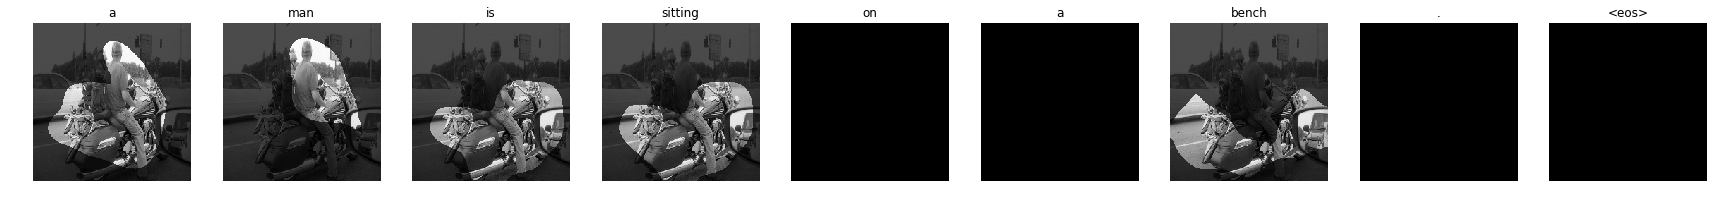

('ID:', u'COCO_val2014_000000559665.jpg', 559665)
('True:', u'black and white photograph of two men on motorcycles . <eos>')
('Gen:', u'a man is sitting on a bench . <eos>')


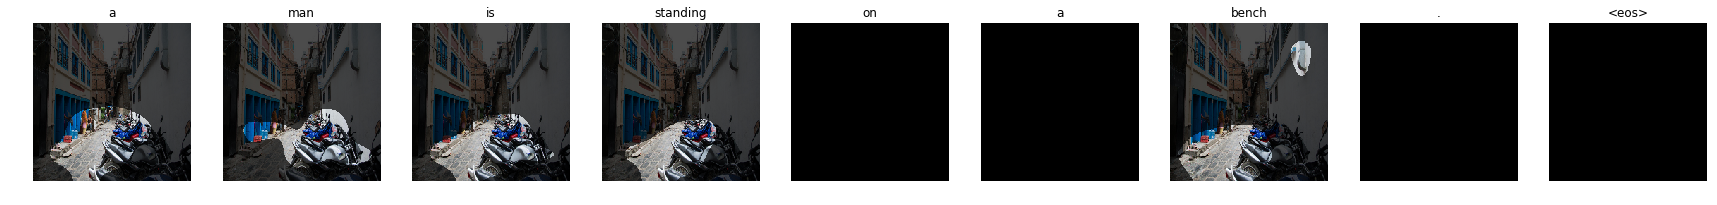

('ID:', u'COCO_val2014_000000394240.jpg', 394240)
('True:', u'a row of motorcycles parked in front of a building . <eos>')
('Gen:', u'a man is standing on a bench . <eos>')


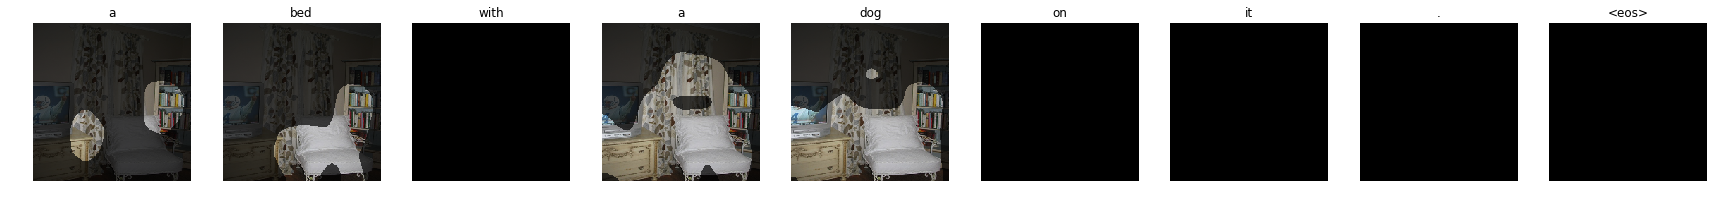

('ID:', u'COCO_val2014_000000491497.jpg', 491497)
('True:', u'a fluffy white chair that faces away fro a television . <eos>')
('Gen:', u'a bed with a dog on it . <eos>')


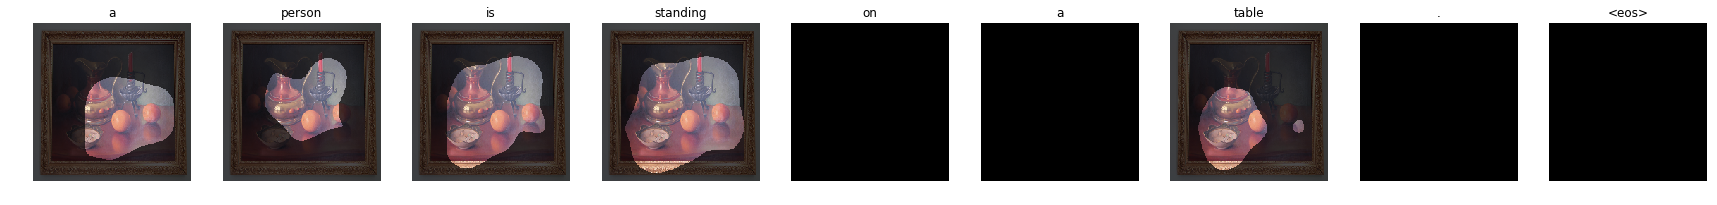

('ID:', u'COCO_val2014_000000184791.jpg', 184791)
('True:', u'a painting of a table with fruit on top of it . <eos>')
('Gen:', u'a person is standing on a table . <eos>')


In [ ]:
from utils.im_proc import read_image
import matplotlib.pyplot as plt  
%matplotlib inline
import os
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter
import copy

IMPATH = os.path.join(args_dict.coco_path,'images','val' + args_dict.year)
count = 0

for [batch_im,prevs],cap,_,imids in val_gen:
    # store all attention maps here
    
    conv_feats = cnn.predict_on_batch(batch_im)
    masks = np.zeros((args_dict.seqlen, args_dict.imsize,args_dict.imsize))
    # first previous word is <start> (idx 1 in vocab)
    prevs = np.zeros((N,1))
    
    # store all predicted words in sequence here
    word_idxs = np.zeros((N,args_dict.seqlen))
    
    imname = imids[0]['file_name']
    img = read_image(os.path.join(IMPATH,imname),(args_dict.imsize,args_dict.imsize))

    # loop to get sequence of predicted words
    for i in range(args_dict.seqlen):

        preds,att = lang_model_att.predict_on_batch([conv_feats,prevs]) #(N,1,vocab_size)
        # store predicted word and set previous word for next step
        preds = preds.squeeze()
        if args_dict.temperature > 0:
            preds = sample(preds,temperature=args_dict.temperature)
        word_idxs[:,i] = np.argmax(preds,axis=-1)
        prevs = np.argmax(preds,axis=-1)
        prevs = np.reshape(prevs,(N,1))
        
        # attention map manipulation for display
        s_att = np.shape(att)[-1]
        att = np.reshape(att,(s_att,))
        if args_dict.sgate:
            s_w = att[-1] # sentinel weight
            att = att[:-1] # remove the sentinel weight from attention weights
            if s_w > 0.5:
                continue # if sentinel weight is higher, then black mask
        s = int(np.sqrt(s_att))
        att = np.reshape(att,(s,s))
        att = zoom(att,float(img.shape[0])/att.shape[-1],order=1)
        att = gaussian_filter(att,sigma=sig)
        att = (att - (np.min(att)))/(np.max(att) - np.min(att))
        att[att>th] = 1
        att[att<=th] = 0.3
        masks[i] = att
    
    # find words for predicted word idxs
    pred_caps = idx2word(word_idxs,inv_vocab)
    true_caps = idx2word(np.argmax(cap,axis=-1),inv_vocab)
    
    # display predictions with attention maps
    n_words = len(pred_caps[0])
    f, axarr = plt.subplots(1,n_words,figsize=figsize)
    for i in range(n_words):
        im = copy.deepcopy(img)
        for c in range(3):
            im[:,:,c] = im[:,:,c]*masks[i]
        axarr[i].imshow(im)
        axarr[i].axis('off')
        axarr[i].set_title(pred_caps[0][i])

    plt.show()
    
    pred_cap = ' '.join(pred_caps[0])
    true_cap = ' '.join(true_caps[0])
    
    # true captions
    print ("ID:", imids[0]['file_name'], imids[0]['id'])
    print ("True:", true_cap)
    print ("Gen:", pred_cap)

    lang_model_att.reset_states()
    count+=1
    if count > 10:
        break